In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import pickle
import os

In [3]:
# Define column names
column_names = [
    'class', 'T3_resin_uptake', 'total_serum_thyroxin', 'total_serum_T3', 'basal_TSH', 'max_diff_TSH'
]

# Load the dataset with error handling
try:
    df = pd.read_csv("thyroid_dataset.csv", header=None, names=column_names)
    print(f"✅ Dataset loaded: {df.shape}")
except FileNotFoundError:
    try:
        df = pd.read_csv("paste.txt", header=None, names=column_names)
        print(f"✅ Dataset loaded: {df.shape}")
    except FileNotFoundError:
        print("❌ Error: Dataset file not found. Please ensure your file is named 'thyroid_dataset.csv' or 'paste.txt'")
        print("Available files:", os.listdir('.'))
        exit()

print(df.head())

✅ Dataset loaded: (215, 6)
   class  T3_resin_uptake  total_serum_thyroxin  total_serum_T3  basal_TSH  \
0    107             10.1                   2.2             0.9        2.7   
1    113              9.9                   3.1             2.0        5.9   
2    127             12.9                   2.4             1.4        0.6   
3    109              5.3                   1.6             1.4        1.5   
4    105              7.3                   1.5             1.5       -0.1   

   max_diff_TSH  
0             1  
1             1  
2             1  
3             1  
4             1  


In [4]:
# Prepare features and target
unique_classes = sorted(df['class'].unique())
if set(unique_classes) == {1, 2, 3}:
    X = df[['T3_resin_uptake', 'total_serum_thyroxin', 'total_serum_T3', 'basal_TSH', 'max_diff_TSH']]
    y = df['class']
elif df.shape[1] == 6:
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X.columns = ['T3_resin_uptake', 'total_serum_thyroxin', 'total_serum_T3', 'basal_TSH', 'max_diff_TSH']
else:
    raise ValueError("Unexpected data structure. Please check your dataset.")

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (215, 5)
Target shape: (215,)


In [5]:
# Check class distribution and filter classes with at least 2 samples to avoid stratify error
print("Class distribution before filtering:")
print(y.value_counts())

counts = y.value_counts()
valid_classes = counts[counts >= 2].index
mask = y.isin(valid_classes)
X = X[mask]
y = y[mask]

print("Class distribution after filtering:")
print(y.value_counts())

Class distribution before filtering:
max_diff_TSH
1    150
2     35
3     30
Name: count, dtype: int64
Class distribution after filtering:
max_diff_TSH
1    150
2     35
3     30
Name: count, dtype: int64


In [6]:
# Class mapping and distribution analysis
class_counts = y.value_counts().sort_index()
unique_classes = sorted(y.unique())
if set(unique_classes) == {1, 2, 3}:
    class_mapping = {1: "Normal", 2: "Hyperthyroid", 3: "Hypothyroid"}
elif len(unique_classes) == 3:
    class_mapping = {unique_classes[0]: "Normal", unique_classes[1]: "Hyperthyroid", unique_classes[2]: "Hypothyroid"}
else:
    class_mapping = {cls: f"Class_{cls}" for cls in unique_classes}

print("Class Distribution:")
for class_val, count in class_counts.items():
    class_name = class_mapping[class_val]
    print(f"  Class {class_val} ({class_name}): {count} samples")

Class Distribution:
  Class 1 (Normal): 150 samples
  Class 2 (Hyperthyroid): 35 samples
  Class 3 (Hypothyroid): 30 samples


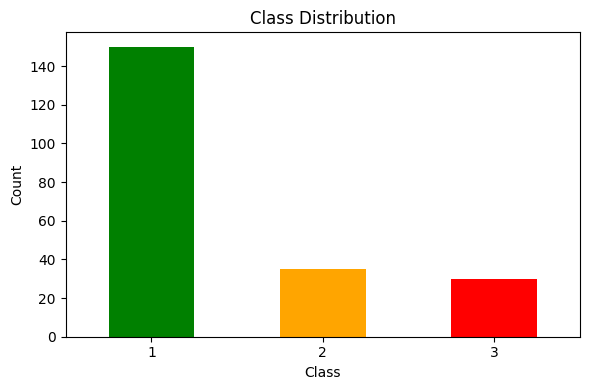

In [7]:
plt.figure(figsize=(6, 4))
y.value_counts().sort_index().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
# Encode classes to 0,1,2
y_encoded = y.map({k: i for i, k in enumerate(sorted(unique_classes))})
class_names = {i: class_mapping[k] for i, k in enumerate(sorted(unique_classes))}

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (172, 5)
Test set shape: (43, 5)


In [9]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Balance training data with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

balanced_counts = pd.Series(y_train_balanced).value_counts().sort_index()
print("After SMOTE balancing:")
for i, count in balanced_counts.items():
    print(f"  Class {i} ({class_names[i]}): {count}")

After SMOTE balancing:
  Class 0 (Normal): 120
  Class 1 (Hyperthyroid): 120
  Class 2 (Hypothyroid): 120


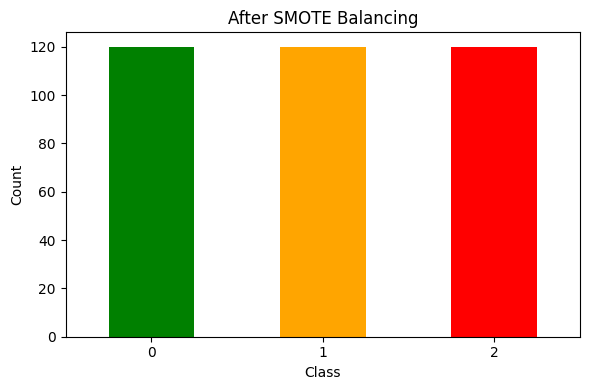

In [11]:
plt.figure(figsize=(6, 4))
balanced_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("After SMOTE Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# Compute class weights for original (unbalanced) training data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Computed class weights:", class_weight_dict)

Computed class weights: {0: np.float64(0.4777777777777778), 1: np.float64(2.0476190476190474), 2: np.float64(2.388888888888889)}


In [13]:
# Define models (Fixed RandomForest and XGBoost parameters for better performance)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(objective='multi:softprob', eval_metric='logloss', use_label_encoder=False, random_state=42, scale_pos_weight=class_weights)
}


Training Logistic Regression...
  Accuracy: 1.0000
  CV Accuracy (Mean): 0.9861 (+/- 0.0088)
  Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        30
Hyperthyroid       1.00      1.00      1.00         7
 Hypothyroid       1.00      1.00      1.00         6

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



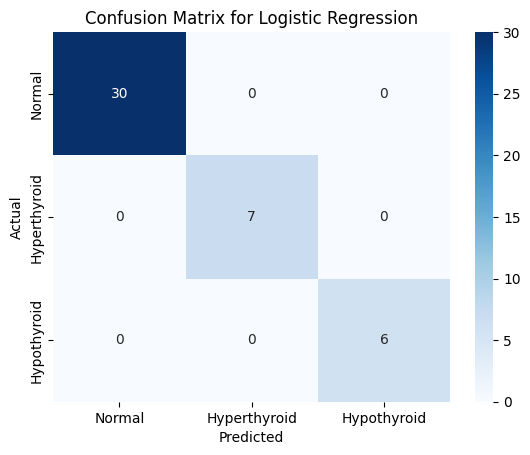


Training Random Forest...
  Accuracy: 0.9767
  CV Accuracy (Mean): 0.9722 (+/- 0.0124)
  Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98        30
Hyperthyroid       1.00      0.86      0.92         7
 Hypothyroid       1.00      1.00      1.00         6

    accuracy                           0.98        43
   macro avg       0.99      0.95      0.97        43
weighted avg       0.98      0.98      0.98        43



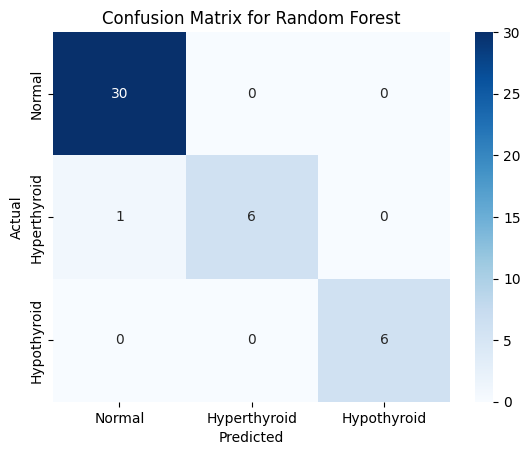


Training Decision Tree...
  Accuracy: 0.9535
  CV Accuracy (Mean): 0.9611 (+/- 0.0269)
  Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97        30
Hyperthyroid       1.00      0.86      0.92         7
 Hypothyroid       1.00      0.83      0.91         6

    accuracy                           0.95        43
   macro avg       0.98      0.90      0.93        43
weighted avg       0.96      0.95      0.95        43



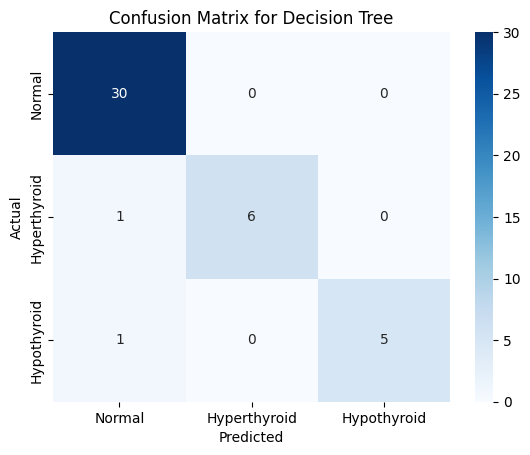


Training SVM...
  Accuracy: 1.0000
  CV Accuracy (Mean): 0.9806 (+/- 0.0068)
  Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        30
Hyperthyroid       1.00      1.00      1.00         7
 Hypothyroid       1.00      1.00      1.00         6

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



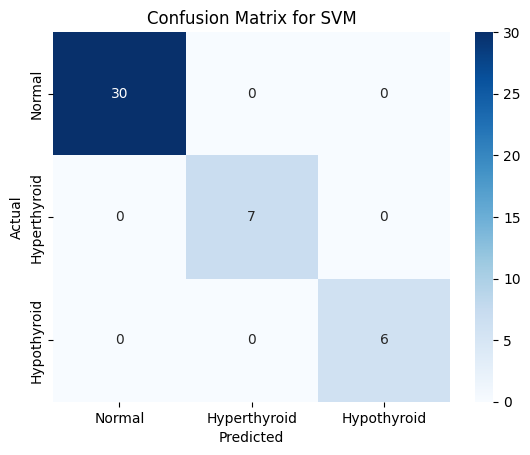


Training XGBoost...


c:\Users\SIDDHARTH\Desktop\Thyroid_Disease_Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:42:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SIDDHARTH\Desktop\Thyroid_Disease_Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:42:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SIDDHARTH\Desktop\Thyroid_Disease_Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:42:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SIDDHARTH\Desktop\Thyroid_Disease_Prediction\venv\Lib\site

  Accuracy: 0.9767
  CV Accuracy (Mean): 0.9778 (+/- 0.0142)
  Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98        30
Hyperthyroid       1.00      0.86      0.92         7
 Hypothyroid       1.00      1.00      1.00         6

    accuracy                           0.98        43
   macro avg       0.99      0.95      0.97        43
weighted avg       0.98      0.98      0.98        43



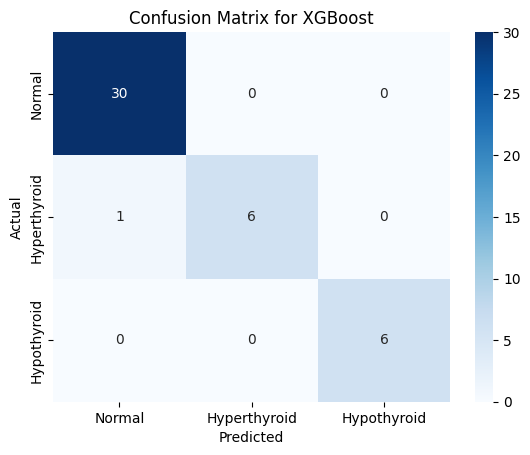

In [16]:
# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=skf, scoring='accuracy')
    
    # Fit the model on the entire balanced training set
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions on the unseen test set
    y_pred = model.predict(X_test_scaled)
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=list(class_mapping.values()), output_dict=True)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_accuracy_mean': np.mean(cv_scores),
        'cv_accuracy_std': np.std(cv_scores),
        'report': report,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  CV Accuracy (Mean): {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
    print(f"  Classification Report:\n{classification_report(y_test, y_pred, target_names=list(class_mapping.values()))}")
    
    sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=list(class_mapping.values()), yticklabels=list(class_mapping.values()))
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [17]:
# Select the best model (now explicitly selecting XGBoost)
best_model_name = "XGBoost"
best_model = results[best_model_name]['model']

print(f"\n🏆 Best Model Selected: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")

# Save the best model, scaler, and class names
# Make sure to create the 'model' directory if it doesn't exist
os.makedirs('model', exist_ok=True)
with open('best_thyroid_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

with open('thyroid_scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)
    
with open('thyroid_class_names.pkl', 'wb') as class_names_file:
    pickle.dump(list(class_names.values()), class_names_file)

print("✅ Best model, scaler, and class names saved as .pkl files.")



🏆 Best Model Selected: XGBoost with accuracy 0.9767
✅ Best model, scaler, and class names saved as .pkl files.
